In [127]:
from pathlib import Path

import math
import random

import numpy as np
import pandas as pd

from numba import njit, prange

from matplotlib import pyplot as plt

In [128]:
def ring_sample(c: tuple, r1: float, r2: float, n: int):
    data = []

    for i in range(n):
        angle = random.uniform(0, 2 * math.pi)
        dist = random.uniform(r1, r2)

        data.append([c[0] + dist * math.cos(angle), c[1] + dist * math.sin(angle)])
    
    return np.array(data)

In [129]:
def one_hot_encoding(n: int, idx: int) -> np.ndarray:
    q = np.zeros(n)
    q[idx] = 1.0
    return q

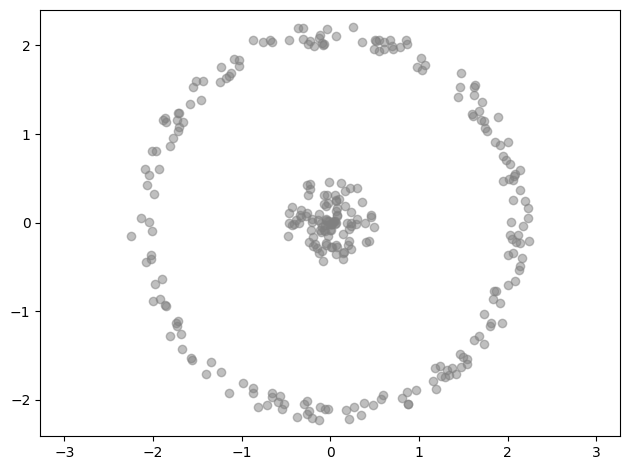

In [130]:
sample1 = ring_sample((0,0), 0, 0.5, 100)
sample2 = ring_sample((0,0), 2, 2.25, 200)

data = np.vstack((sample1, sample2))

plt.scatter(data[:,0], data[:,1], c='gray', alpha=0.5)

plt.axis('equal')
plt.tight_layout()
plt.show()

In [131]:
x_train = data
y_train = np.vstack((
    [one_hot_encoding(2, 0) for i in range(100)],
    [one_hot_encoding(2, 1) for i in range(200)]
))

In [132]:
@njit(fastmath=True)
def ReLU(x: np.ndarray) -> np.ndarray:
    return np.maximum(np.zeros(x.shape), x)


@njit(fastmath=True)
def dReLU(x: np.ndarray) -> np.ndarray:
    return 1 * (x > 0)


@njit(fastmath=True)
def sigmoid(x: np.ndarray) -> np.ndarray:
    return 1 / (1 + np.exp(-x))


@njit(fastmath=True)
def dSigmoid(x: np.ndarray) -> np.ndarray:
    y = 1 / (1 + np.exp(-x))
    return y * (1 - y)


@njit(fastmath=True)
def softmax(x: np.ndarray) -> np.ndarray:
    y = np.exp(x)
    return y / np.sum(y)

In [138]:
@njit(fastmath=True)
def grads(xBatch: np.ndarray, yBatch: np.ndarray, W: np.ndarray, b: np.ndarray) -> tuple[np.ndarray]:
    dW = np.zeros(W.shape)
    db = np.zeros(b.shape)

    u = np.zeros((W.shape[0], W.shape[1]))
    # h = np.zeros(W.shape[1])
    
    for i in range(xBatch.shape[0]):

        for j in range(W.shape[0]):
            u[j] = W[j] @ xBatch[i] + b[j]
            # h += sigmoid(u[j])

        h = np.sum(u, axis=0)
        y = softmax(h)

        for j in range(W.shape[0]):
            # dLdu = (y - yBatch[i]) * dSigmoid(u[j])
            dLdu = y - yBatch[i]
            dW[j] += np.outer(dLdu, xBatch[i])
            db[j] += dLdu
                
    return (dW, db)


class WidePerceptron:
    def __init__(self, nIn: int, nL:int, nOut: int) -> None:
        self.nIn = nIn
        self.nL = nL
        self.nOut = nOut
        
        self.W: np.ndarray = np.random.uniform(-1, 1, (nL, nOut, nIn))
        self.b: np.ndarray = np.zeros((nL, nOut))

    def predict(self, x:np.ndarray) -> np.ndarray:
        y = np.zeros(self.nOut)

        for i in range(self.nL):
            # y += sigmoid(self.W[i] @ x + self.b[i])
            y += self.W[i] @ x + self.b[i]
                
        return softmax(y)

    def loss(self, x: np.ndarray, y: np.ndarray) -> float:
        Ypred = np.array([self.predict(xi) for xi in x])
        h = -np.mean(y*np.log(Ypred), axis=1)
        return np.mean(h)

    def train(self, x_train: np.ndarray, y_train: np.ndarray, lr, batch_size, max_epoch) -> None:
        n = x_train.shape[0]

        for epoch in range(max_epoch):
            idxs = np.random.permutation(n)

            for batch_idx in range(n//batch_size):
                ibegin, iend = batch_idx*batch_size, min((batch_idx+1)*batch_size, n-1)
                batch_idxs = idxs[ibegin:iend]
            
                dW, db = grads(x_train[batch_idxs], y_train[batch_idxs], self.W, self.b)

                self.W -= lr*dW
                self.b -= lr*db

In [179]:
nIn = 2
nOut = 2
nL = 4

learning_rate = 1e-2
batch_size = 16
max_epoch = 100

model = WidePerceptron(nIn, nL, nOut)

print('untrained loss: {0:.6f}'.format(model.loss(x_train, y_train)))

model.train(x_train, y_train, learning_rate, batch_size, max_epoch)

print('trained loss: {0:.6f}'.format(model.loss(x_train, y_train)))

TP_count = 0
for x, y in zip(x_train, y_train):
    yPred = model.predict(x)
    TP_count += 1 if np.argmax(y) == np.argmax(yPred) else 0

accuracy = TP_count / x_train.shape[0]
print(f"test set accuracy: {round(accuracy*100, 2)}%")

untrained loss: 0.421450
trained loss: 0.321349
test set accuracy: 56.33%


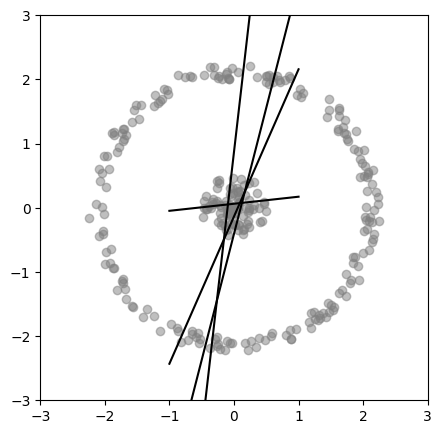

In [180]:
fig, axes = plt.subplots(nrows=1, ncols=1)

fig.set_dpi(100)
fig.set_figwidth(5)
fig.set_figheight(5)

x = np.linspace(-1, 1, 100)

axes.scatter(x_train[:,0], x_train[:,1], c='gray', alpha=0.5)

for i in range(model.nL):
    w1 = model.W[i][0][0]
    w2 = model.W[i][0][1]
    b = model.b[i][0]

    A = -w1/w2
    B = -b/w2

    y = A * x + B

    axes.plot(x, y, c='black')

plt.xlim(-3,3)
plt.ylim(-3,3)

# plt.autoscale()
# plt.tight_layout()
# plt.axis('equal')
plt.show()